The idea is to create some new imbeddings for the "ground truth" of each object with an added semantic direction. "a photo of a {ground truth} from {direction}".

In [1]:
from clip_pipeline import CLIPModel
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil, sqrt

model = CLIPModel()
with open('Embeddings/Dataset.json', 'r') as f:
    dataset = json.load(f)
with open('Data/Dataset/GT_labels.json', 'r') as f:
    GT_labels = json.load(f)

In [49]:
# semantic direction
direction = [
   # Basic geometric directions
   "front", "back", "left", "right", #"side", "top", "bottom",
   
   # Perspective/viewpoint terms
   #"above", "below", "overhead", "underneath", "behind", "forward", "backward", "sideways", "profile",
   
   # Angular/rotational
   #"diagonal", "angled", "tilted", "rotated", "upright", "inverted", "horizontal", "vertical",
]

# compute semantic embeddings
labels, semantic_labels = list(), list()
for i,obj in enumerate(dataset["rot"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]} from the"))
    semantic_labels.append([])
    for v in range(len(direction)):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} from the {direction[v]}."))
        #semantic_labels[i].append(model.embed(f"{direction[v]}"))

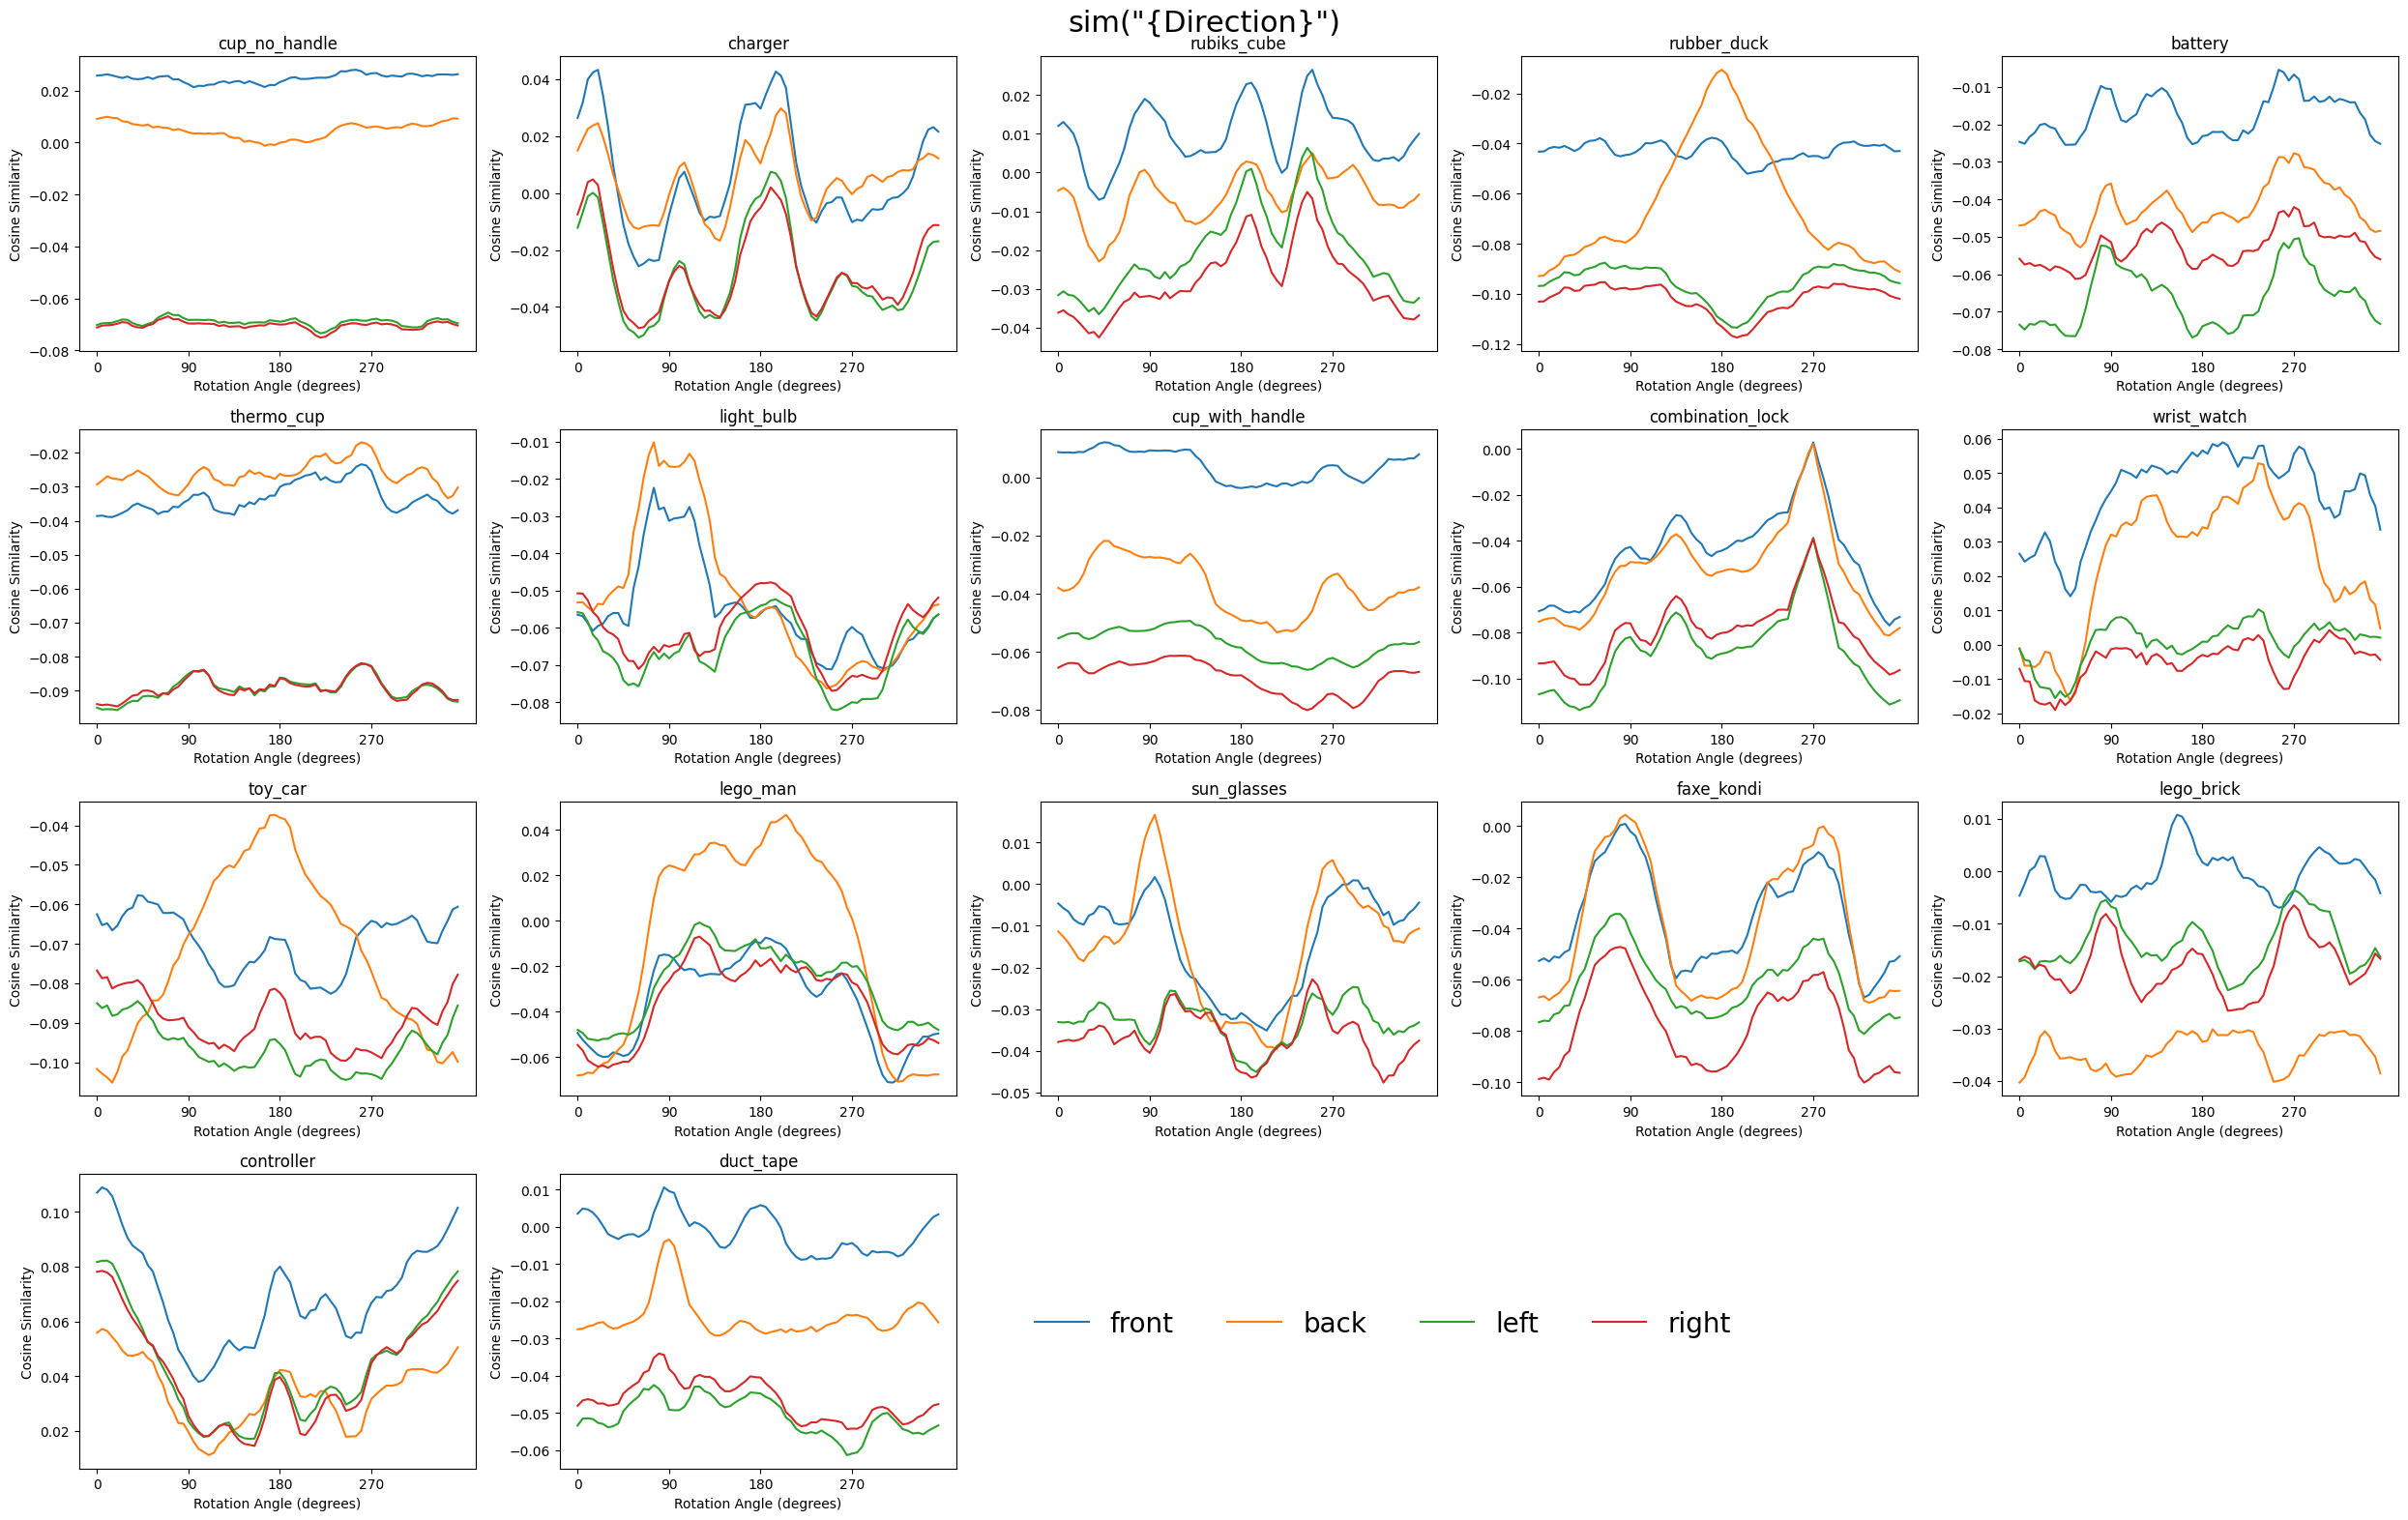

In [50]:
num_objs = len(dataset["rot"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

total_all_sims = []
for obj_idx, (obj, ax) in enumerate(zip(dataset["rot"].keys(), axes.flat)):
    all_sims = []
    for i in range(72):
        sims = []
        for v in range(len(direction)):
            sim_semantic = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]-labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = sim_semantic - sim
            sims.append(sim_semantic)
        
        all_sims.append(sims)
    total_all_sims.append(all_sims)
    for v in range(len(direction)):
        sims = [all_sims[i][v] for i in range(72)]
        # Smooth the curve using a moving average with circular (wrap-around) padding
        window = 5
        sims_arr = np.array(sims)
        if len(sims_arr) >= window:
            pad = window // 2
            sims_padded = np.concatenate([sims_arr[-pad:], sims_arr, sims_arr[:pad]])
            sims_smoothed = np.convolve(sims_padded, np.ones(window)/window, mode='valid')
        else:
            sims_smoothed = sims_arr
        ax.plot(range(72), sims_smoothed, label=f'{direction[v]}')
        ax.set_xticks([i*18 for i in range(4)])
        ax.set_xticklabels([f'{i*90}' for i in range(4)])
        ax.set_xlabel('Rotation Angle (degrees)')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'{obj}')

fig.suptitle('sim("{Direction}")', fontsize=22)

handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_,
           ncol=4,
           loc='center left',
           bbox_to_anchor=(0.42, 0.13),
           fontsize=20,
           frameon=False)

for idx in range(num_objs, rows * cols):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.show()



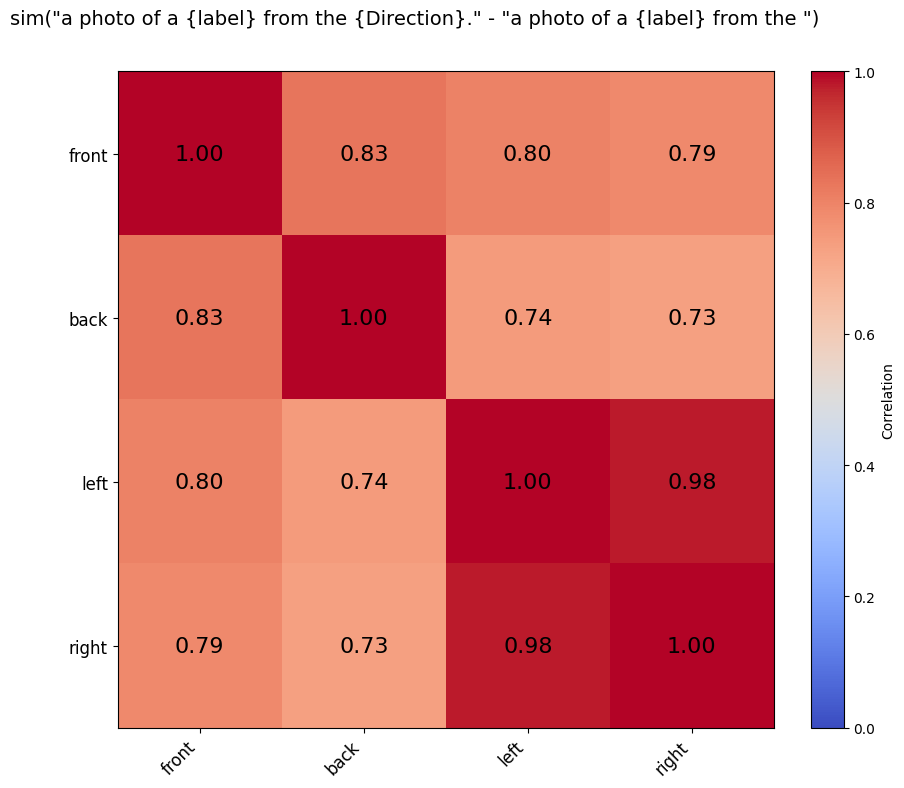

In [51]:
# Convert all_sims to a numpy array for easier manipulation
all_sims_arr = np.vstack(total_all_sims)  # shape: (num_objs*72, len(direction))

# Compute correlation matrix between the directions
corr_matrix = np.corrcoef(all_sims_arr, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')

# Set ticks and labels
ax.set_xticks(np.arange(len(direction)))
ax.set_yticks(np.arange(len(direction)))
ax.set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(direction, fontsize=12)

# Annotate correlation values
for i in range(len(direction)):
    for j in range(len(direction)):
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=16)

fig.suptitle('sim("a photo of a {label} from the {Direction}." - "a photo of a {label} from the ")', fontsize=14)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


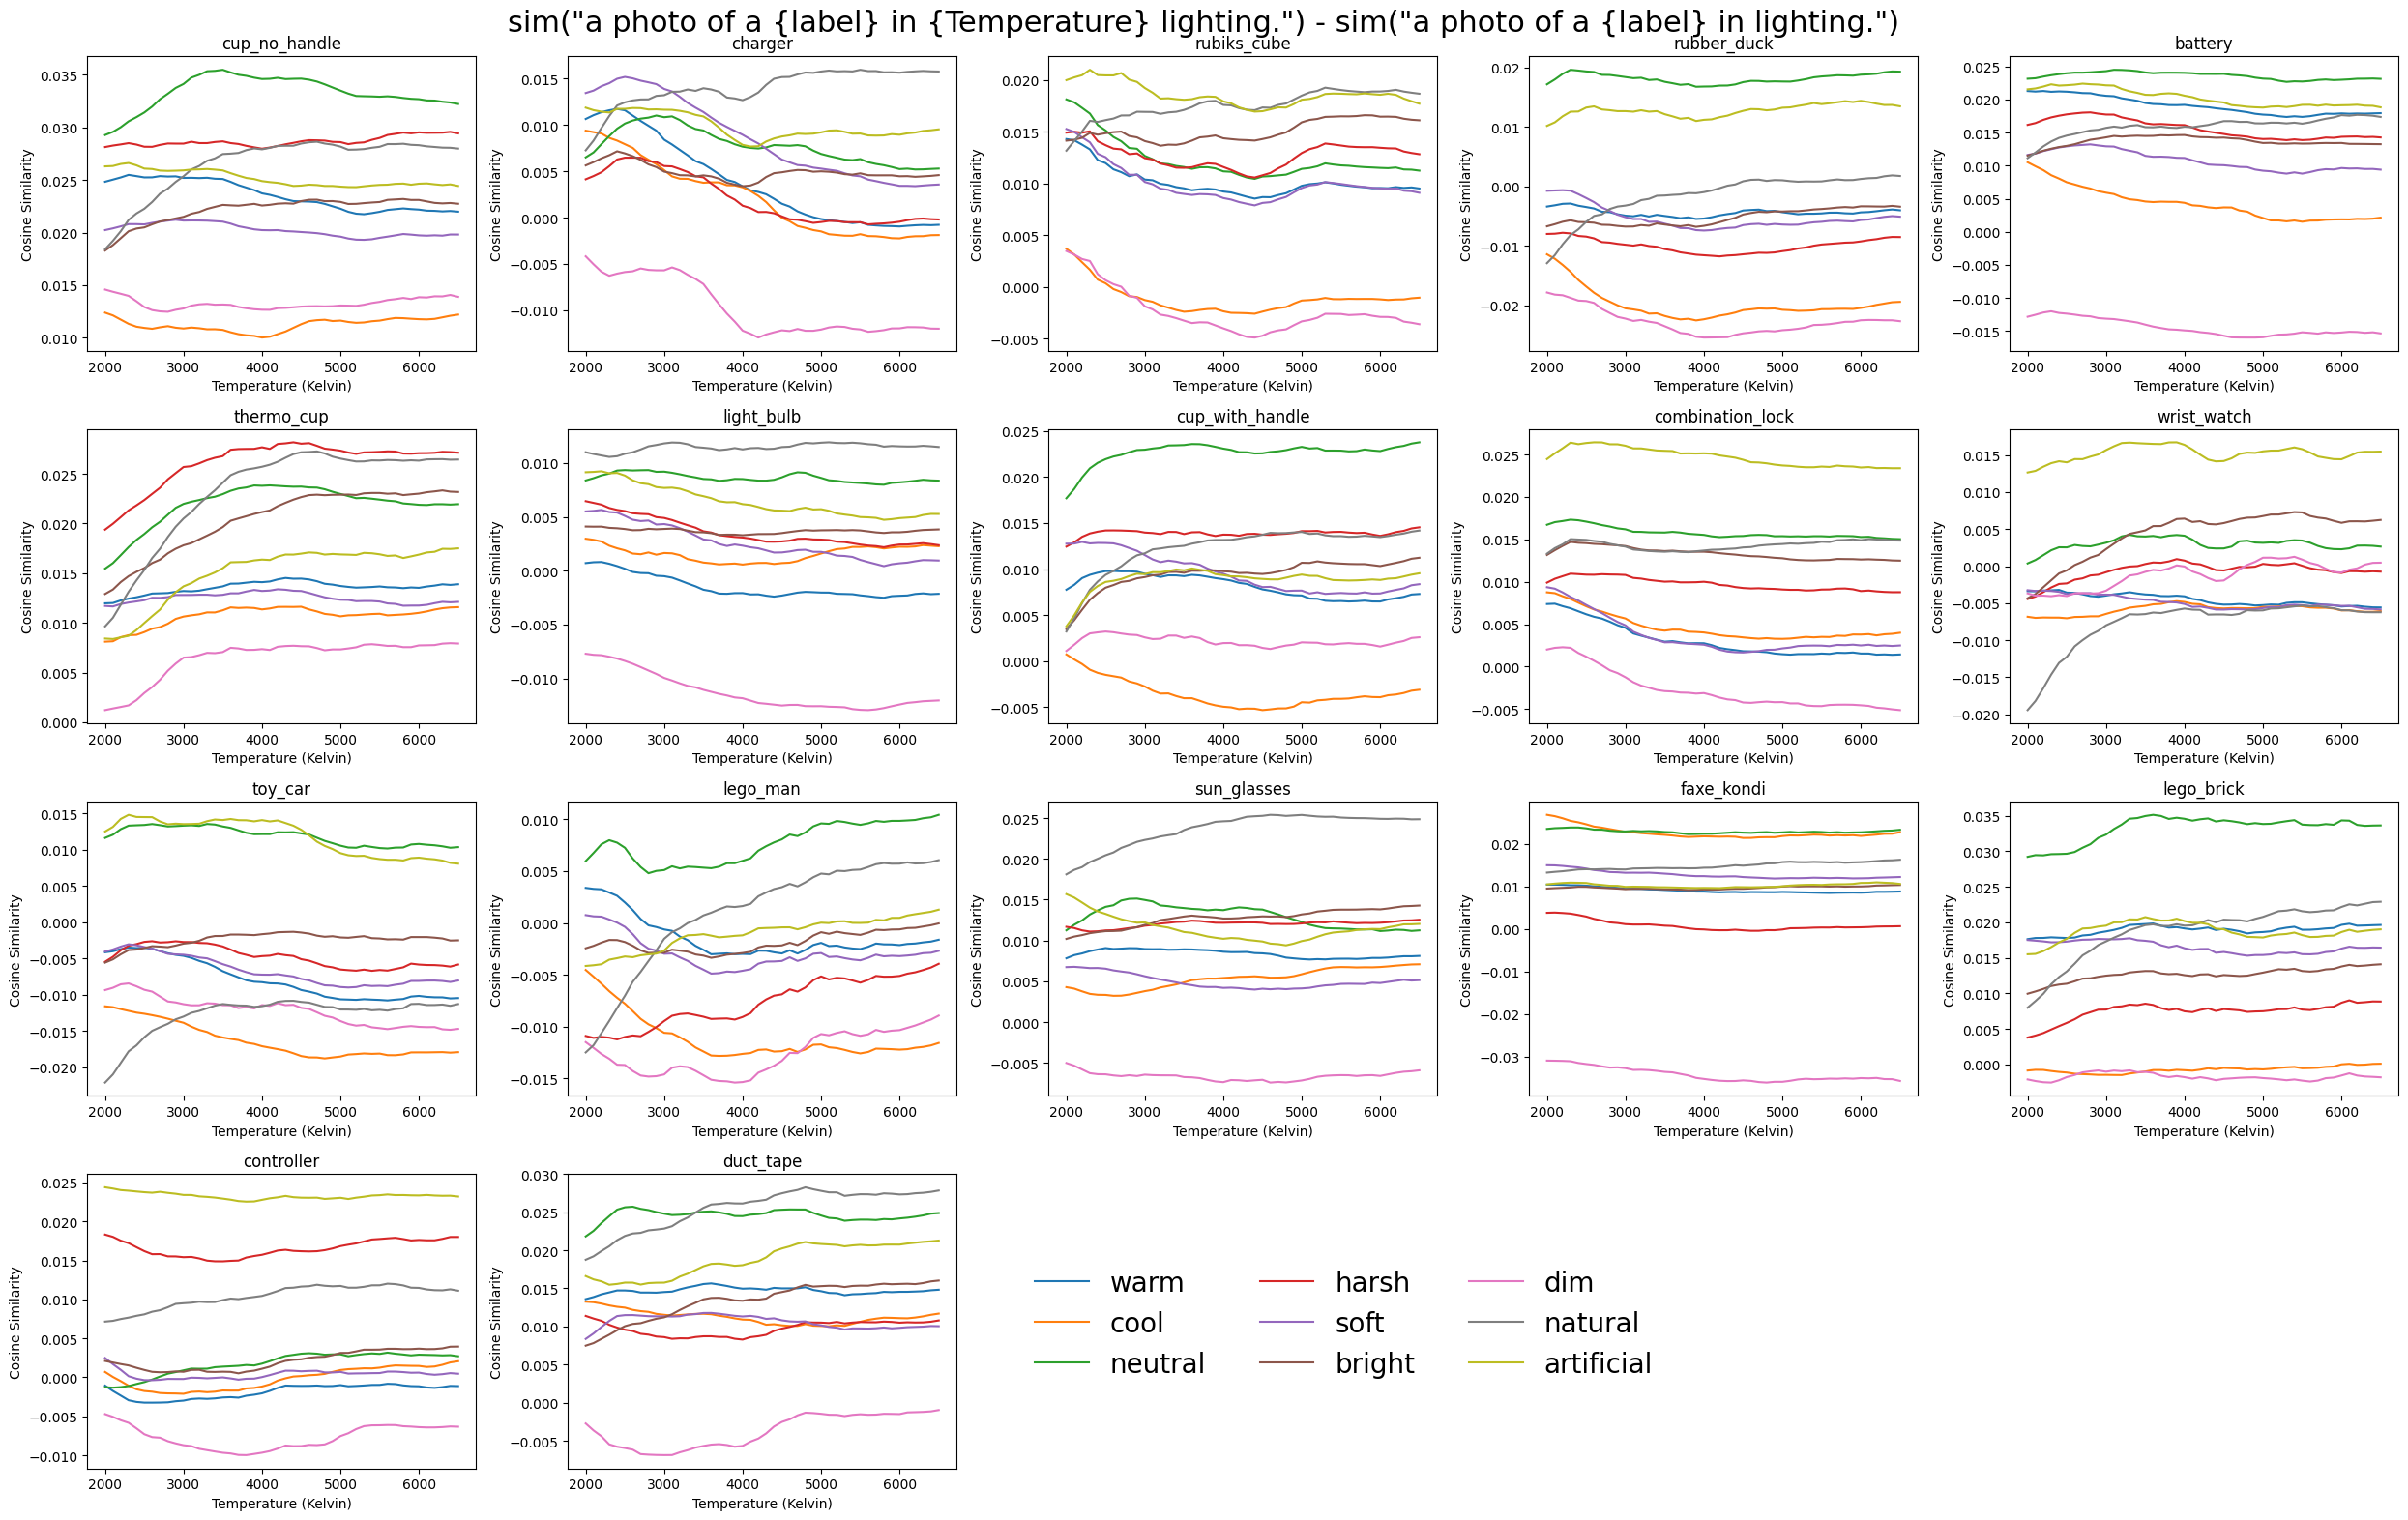

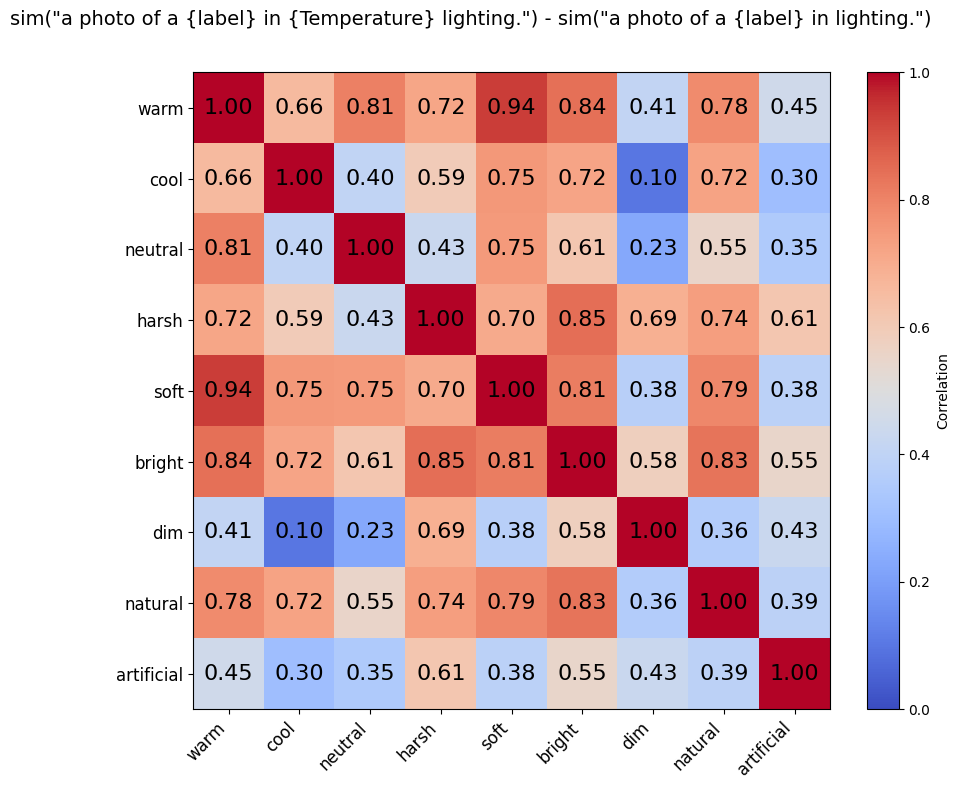

In [ ]:
# semantic "direction" (temperature) instead of changing the code
direction = ["warm", "cool", "neutral", "harsh", "soft", "bright", "dim", "natural", "artificial"]

# compute semantic embeddings
labels, semantic_labels = list(), list()
for i,obj in enumerate(dataset["temp"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]} in lighting."))
    semantic_labels.append([])
    for v in range(len(direction)):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} in {direction[v]} lighting."))
        #semantic_labels[i].append(model.embed(f"{direction[v]}"))


num_objs = len(dataset["temp"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

total_all_sims = []
for obj_idx, (obj, ax) in enumerate(zip(dataset["temp"].keys(), axes.flat)):
    all_sims = []
    for i in range(46):
        sims = []
        for v in range(len(direction)):
            sim_semantic = cosine_similarity(
                np.array(dataset["temp"][obj][f"{2000 + i*100}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]).reshape(1, -1)
            )[0, 0]
            sim = cosine_similarity(
                np.array(dataset["temp"][obj][f"{2000 + i*100}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = sim_semantic - sim
            sims.append(sim_delta)
        
        all_sims.append(sims)
    total_all_sims.append(all_sims)
    for v in range(len(direction)):
        sims = [all_sims[i][v] for i in range(46)]
        # Smooth the curve using a moving average with circular (wrap-around) padding
        window = 5
        sims_arr = np.array(sims)
        if len(sims_arr) >= window:
            pad = window // 2
            sims_padded = np.pad(sims_arr, (pad, pad), mode='edge')
            sims_smoothed = np.convolve(sims_padded, np.ones(window)/window, mode='valid')
        else:
            sims_smoothed = sims_arr
            sims_smoothed = sims_arr
        ax.plot(range(46), sims_smoothed, label=f'{direction[v]}')
        ax.set_xticks([i*10 for i in range(5)])
        ax.set_xticklabels([f'{2000 + i*1000}' for i in range(5)])
        ax.set_xlabel('Temperature (Kelvin)')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'{obj}')

fig.suptitle('sim("a photo of a {label} in {Temperature} lighting.") - sim("a photo of a {label} in lighting.")', fontsize=22)

handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_,
           ncol=3,
           loc='center left',
           bbox_to_anchor=(0.42, 0.13),
           fontsize=20,
           frameon=False)

for idx in range(num_objs, rows * cols):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.show()

# Convert all_sims to a numpy array for easier manipulation
all_sims_arr = np.vstack(total_all_sims)  # shape: (num_objs*72, len(direction))

# Compute correlation matrix between the directions
corr_matrix = np.corrcoef(all_sims_arr, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')

# Set ticks and labels
ax.set_xticks(np.arange(len(direction)))
ax.set_yticks(np.arange(len(direction)))
ax.set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(direction, fontsize=12)

# Annotate correlation values
for i in range(len(direction)):
    for j in range(len(direction)):
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=16)

fig.suptitle('sim("a photo of a {label} in {Temperature} lighting.") - sim("a photo of a {label} in lighting.")', fontsize=14)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()